In [1]:
import torch
import clip
import os
import sys
import torch
import torchvision.transforms as T
import time
import shutil
from os.path import join
from torchvision.transforms import ToPILImage

base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "clip_image_encoder/")

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)

from stable_diffusion2.stable_diffusion import StableDiffusion
from stable_diffusion2.model.clip_image_encoder import CLIPImageEncoder
from labml.monit import section
# from stable_diffusion2.utils.utils import SectionManager as section
from stable_diffusion2.utils.model import *
from stable_diffusion2.utils.utils import *
from stable_diffusion2.constants import ModelsPathTree
from pathlib import Path

[WinError 3] The system cannot find the path specified: '.././output/sd2-notebook/clip_image_encoder/' 
 Creating the path...


In [2]:
batch_size = 1
device = check_device(None)
pt = ModelsPathTree(base_directory=base_directory)

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [3]:
sd = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [5]:
# let's start embedding a prompt and saving it

sd.quick_initialize().load_clip_embedder(**pt.embedder).load_submodels(**pt.embedder_submodels)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10124 MiB
Used: 2163 MiB


In [6]:
# get the text embeddings
uncond, cond = sd.get_text_conditioning(uncond_scale = 7.5, prompts = ["A computer virus dancing tango."])
get_memory_status()

Total: 12287 MiB
Free: 9620 MiB
Used: 2667 MiB


In [7]:
# check their shape
uncond.shape, cond.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [8]:
# save them to disk
torch.save(uncond, join(output_directory, "uncond.pt"))
torch.save(uncond, join(output_directory, "cond.pt"))

In [11]:
# load the unet, needed for the sampling
sd.model.load_unet(**pt.unet)
get_memory_status()

Total: 12287 MiB
Free: 2974 MiB
Used: 9313 MiB


In [14]:
# load the decoder, needed for getting the sampled image back from the latent space
sd.model.load_autoencoder(**pt.autoencoder).load_decoder(**pt.decoder)
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 2974 MiB
Used: 9313 MiB


In [15]:
images = sd.generate_images_from_embeddings(null_prompt = uncond, embedded_prompt=cond, batch_size = batch_size)
get_memory_status()

cond shape:  torch.Size([1, 77, 768])
uncond shape:  torch.Size([1, 77, 768])


HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

Total: 12287 MiB
Free: 0 MiB
Used: 12287 MiB


In [16]:
images.shape

torch.Size([1, 3, 512, 512])

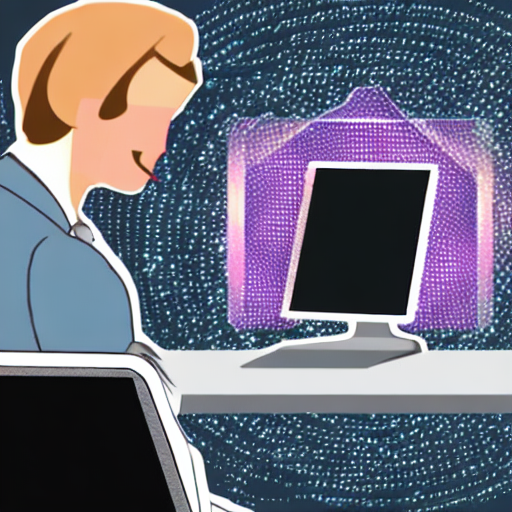

In [17]:
if batch_size > 1:
    grid = torchvision.utils.make_grid(images, nrow=2, normalize=False, range=(-1, 1))
    img = to_pil(grid)
else:
    img = to_pil(images[0])
img

In [18]:
sd.unload_model()
get_memory_status()

Total: 12287 MiB
Free: 9348 MiB
Used: 2939 MiB


In [19]:
images.shape

torch.Size([1, 3, 512, 512])

In [20]:
img_encoder = CLIPImageEncoder(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 9348 MiB
Used: 2939 MiB


In [23]:
img_encoder.load_clip_model(**pt.clip_model)
get_memory_status()
img_encoder.initialize_preprocessor()

Total: 12287 MiB
Free: 7596 MiB
Used: 4691 MiB
Initializing image preprocessor...


In [24]:
img_encoder.image_processor

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [25]:
prep_from_img = img_encoder.preprocess_input(img).to(device)
type(img)

c:\Users\igor-\anaconda3\envs\kcg\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


PIL.Image.Image

In [26]:
img_encoder.image_processor

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [27]:
prep_from_tensor = img_encoder.preprocess_input(images)
type(images)

torch.Tensor

In [28]:
prep_from_img.shape, prep_from_tensor.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [29]:
torch.all(prep_from_img.to(device) == prep_from_tensor)

tensor(False, device='cuda:0')

In [30]:
torch.norm(prep_from_img.to(device) - prep_from_tensor)

tensor(6.0335, device='cuda:0')

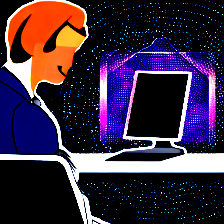

In [31]:
to_pil(prep_from_img.squeeze(0))

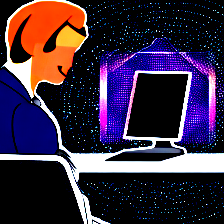

In [32]:
to_pil(prep_from_tensor.squeeze(0))

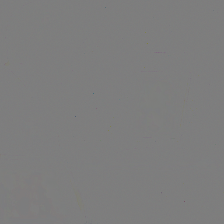

In [33]:
to_pil((prep_from_img - prep_from_tensor).squeeze(0))

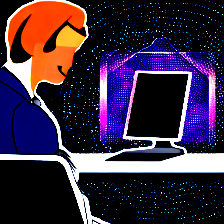

In [34]:
if batch_size > 1:
    grid = torchvision.utils.make_grid([prep_from_img, prep_from_tensor], nrow=2, normalize=False, range=(-1, 1))
    img = to_pil(grid)
else:
    img = to_pil(prep_from_img.squeeze(0))
img

In [35]:
grid = torchvision.utils.make_grid([prep_from_img.squeeze(), prep_from_tensor.squeeze()], nrow=2, normalize=False, range=(-1, 1))
img = to_pil(grid)

In [36]:
img_features_tensor = img_encoder(prep_from_tensor)
img_features_tensor.shape

torch.Size([1, 768])

In [37]:
img_features_image = img_encoder(prep_from_img)
img_features_image.shape

torch.Size([1, 768])

In [38]:
torch.norm(img_features_image - img_features_tensor)

tensor(0.5420, device='cuda:0', dtype=torch.float16)